In [1]:
from bert_functions_v2 import analyzeWord, getBert
from createDims import createPolarDimension
from get_data_from_file import create_lookup_from_data_file,create_lookupFiles_out_of_adjectives_list_using_file
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import pickle
import json
import string
import ast
import torch
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [10]:
def get_name(antonym):
    return wn.synset(antonym).lemma_names()[0]


def get_examples(antonym):
    antonym= wn.synset(antonym)
    examples=antonym.examples()
    #save only examples that containt the required word
    correct_examples=[]
    for example in examples:
        if re.search(r'\b'+str(antonym.lemma_names()[0])+'\\b', example, re.I) is not None:
            correct_examples.append(example)
    

    
    examples = [sent.translate(str.maketrans({k: " " for k in string.punctuation})) for sent in correct_examples]
    # add a space after each sentence
    return ['{} '.format(sent) for sent in examples]



def create_lookup_files(antonyms, lookup_path):
    if len(np.unique(antonyms, axis=0)) != len(antonyms):
        print("Your antonym list contains duplicates. Please try again!")
        return
    
    # get all word sense definitions
    synset_defs = [[wn.synset(anto).definition() for anto in pair] for pair in antonyms]
    # get example sentences from wordnet
    examples_readable = {str(pair):{get_name(anto): get_examples(anto) for anto in pair} for pair in antonyms}
    examples_lookup = [[[get_name(anto), get_examples(anto)] for anto in pair] for pair in antonyms]
    
    # save 
    with open(out_path + 'lookup_synset_dict.txt', 'w') as t:
        t.write(json.dumps(antonyms, indent=4))
    with open(out_path + 'lookup_synset_dict.pkl', 'wb') as p:
        pickle.dump(antonyms, p)
    with open(lookup_path + 'lookup_synset_definition.txt', 'w') as t:
        t.write(json.dumps(synset_defs, indent=4))  
    with open(lookup_path + 'lookup_synset_definition.pkl', 'wb') as p:
        pickle.dump(synset_defs, p)        
    with open(lookup_path + 'antonym_wordnet_example_sentences_readable_extended.txt', 'w') as t:
        t.write(json.dumps(examples_readable, indent=4))  
    with open(lookup_path + 'lookup_anto_example_dict.txt', 'w') as t:
        t.write(json.dumps(examples_lookup, indent=4))      
    with open(lookup_path + 'lookup_anto_example_dict.pkl', 'wb') as p:
        pickle.dump(examples_lookup, p)
    return


In [2]:
def create_dimensions_list():
    from collections import defaultdict
    word="1"
    #d for dimensions
    d=[]
    while word != '' :
        antonyms=defaultdict()
        index=0
        word=input('Enter word: ')
        if word !='':
            #get all synstets
            synsets=wn.synsets(word)

            #create dictionary only with synsets that have an antonym
            for i in synsets:
                if(len(i.lemmas()[0].antonyms()) !=0):
                    ant=i.lemmas()[0].antonyms()[0]
                    antonyms[i]=ant.synset()
                    
            #keep only antonym pairs that have examples
            for key in list(antonyms.keys()):
                if (len(key.examples())==0 or len(antonyms[key].examples())==0):
                    del antonyms[key]


            #visualize definitions

            for key in list(antonyms.keys()):
                print("Antonym pair index {}".format(index))
                print("   Antonym pair {}-----{} ".format(key,antonyms[key]))
                print("        Definition {} => {} ".format(key,key.definition()))
                print("        Definition {} => {} ".format(antonyms[key],antonyms[key].definition()))
                print(" ")
                print(" ")
                print(" ")
                index+=1
            
            #create list of desired dimensions 
            selected_antonym_pair_index=int(input('Enter the index of desired antonym pair: '))

            key=list(antonyms.keys())[selected_antonym_pair_index]

            d.append(list([key.name(),antonyms[key].name()]))
            print(" ")
            print(" ")
            print(" ")

    return d



In [4]:
def preprocess_context(context):
    context=context.split('.')
    for value in context:
        if len(value)<10:
            context.remove(value)
    train_tokens = list(map(lambda t: '[CLS]' +" "+ t, context))
    
    return train_tokens

def create_file (ex1,ex2,name):
    data = [{'a': '[CLS]', 'b': '[CLS]', 'c': ex1,'d':ex2}] 
    df=pd.DataFrame(data)
    
    
    name='{}CLS.xlsx'.format(name)
    
    df.to_excel(name,index=None)
    
    return name

def preprocess_examples (examples1,examples2):
    examples1=preprocess_context(examples1)
    examples2=preprocess_context(examples2)
    

    
    examples1_file=examples1[0:20]
    examples1_test=examples1[20::]
    
    
    examples2_file=examples2[0:20]
    examples2_test=examples2[20::]
    
    
    #concatenate test sentences
    
    test_sentences= [*examples1_test, *examples2_test]
    
    
    s='.'
    s=s.join(examples1_file)
    
    s1='.'
    s1=s1.join(examples2_file)
    
    examples_file=s+s1
    
    return examples_file,test_sentences





def create_df(dictionary):
    results=pd.DataFrame()
    results['sentece']=dictionary.keys()
    results['sense_polar']=dictionary.values()
    res=[]
    for value in dictionary.values():
        if value < 0:
            res.append(0)
        else :
            res.append(1)

    results=results.assign(Results= res)

    xs = [0] * 20 + [1]*20

    results=results.assign(Truth= xs)
    
    return results



def SensePolar(file,sentences,out):

    create_lookup_from_data_file(file,out)

    # get the embedding model 
    tokenizer, model = getBert()
    print("Model imported")

    # create the base change matrix (this might take some time)
    createPolarDimension(model, tokenizer, out_path=out, antonym_path=out + "antonym_wordnet_example_sentences_readable_extended.txt")
    print("dimensions created")


    # base change does not work well with only few dimensions -> compare with projection
    antonym_path = out + "polar_dimensions.pkl"

    word = '[CLS]'
    resultsdictionary=defaultdict()
    for sent in sentences:
        
        res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out, numberPolar=1,method="projection")
        resultsdictionary[sent]=float(list(res[2].values())[0])
        
    return resultsdictionary


def confusion_matrix(df):
    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    
    actual = df.Truth
    predicted =  df.Results

    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    return plt.show()



def add_values(ant_pair,df,final):
    actual = df.Truth
    predicted =  df.Results
    
    final.loc[len(final)] = [ant_pair,metrics.f1_score(actual, predicted), metrics.recall_score(actual, predicted),  
                             metrics.precision_score(actual, predicted), metrics.accuracy_score(actual, predicted),
                            len(df)]
    
    return final

In [5]:
final=pd.DataFrame()
final=final.assign(Antonym_pair="")
final=final.assign(F1="")
final=final.assign(RECALL="")
final=final.assign(PRESICION="")
final=final.assign(ACCURACY="")
final=final.assign(Number_of_predictions="")

final

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions


# good--bad

In [3]:
contextGoodBad=["A kind gesture from a stranger. A good book that captures your imagination.",
"A peaceful moment in nature.",
"A favorite song that makes you happy.",
"A cozy blanket on a chilly day.",
"A successful workout that leaves you feeling energized.",
"A cute animal video that brings a smile to your face.",
"A heartfelt conversation with a friend.",
"A delicious dessert that satisfies your sweet tooth.",
"A clean and organized living space.",
"A thoughtful gift from someone special.",
"A beautiful flower garden in full bloom.",
"A new opportunity that excites you.",
"A sense of purpose and direction in life.",
"A kind compliment from someone you respect.",
"A day off to relax and recharge.",
"A delicious meal shared with loved ones.",
"A beautiful piece of art that speaks to you.",
"A successful career or personal achievement.",
"A warm and welcoming community.",
"A sense of gratitude for the good things in life.",
"The smell coming from the garbage can was nauseating.",
"The food at the restaurant was undercooked and gave me food poisoning.",
"The car accident caused multiple injuries and fatalities.",
"The thunderstorm caused severe flooding in the town.",
"The house was infested with termites and had extensive damage.",
"The company laid off hundreds of employees without warning.",
"The news of a loved one's passing was heartbreaking.",
"The thief stole all of the valuables from the house.",
"The online scammer stole thousands of dollars from unsuspecting victims.",
"The pollution in the air caused respiratory problems for many people.",
"The earthquake caused widespread destruction and loss of life.",
"The computer virus wiped out all of the important files on the computer.",
"The political scandal caused a loss of trust in the government.",
"The food recall was issued after multiple people got sick from eating contaminated products.",
"The bullying at school caused emotional and psychological damage to the victim.",
"The addiction to drugs ruined the person's life and relationships.",
"The fraud committed by a trusted employee caused financial ruin for the company.",
"The natural disaster destroyed homes and businesses, leaving many homeless.",
"The discrimination against certain groups of people caused harm and inequality.",
"The violence in the city led to a rise in crime and fear among residents."]

In [6]:
train_tokens = list(map(lambda t: '[CLS]' +" "+ t, contextGoodBad))

In [7]:
train_tokens

['[CLS] A kind gesture from a stranger. A good book that captures your imagination.',
 '[CLS] A peaceful moment in nature.',
 '[CLS] A favorite song that makes you happy.',
 '[CLS] A cozy blanket on a chilly day.',
 '[CLS] A successful workout that leaves you feeling energized.',
 '[CLS] A cute animal video that brings a smile to your face.',
 '[CLS] A heartfelt conversation with a friend.',
 '[CLS] A delicious dessert that satisfies your sweet tooth.',
 '[CLS] A clean and organized living space.',
 '[CLS] A thoughtful gift from someone special.',
 '[CLS] A beautiful flower garden in full bloom.',
 '[CLS] A new opportunity that excites you.',
 '[CLS] A sense of purpose and direction in life.',
 '[CLS] A kind compliment from someone you respect.',
 '[CLS] A day off to relax and recharge.',
 '[CLS] A delicious meal shared with loved ones.',
 '[CLS] A beautiful piece of art that speaks to you.',
 '[CLS] A successful career or personal achievement.',
 '[CLS] A warm and welcoming community.

In [8]:
dims=create_dimensions_list()

Enter word: good
Antonym pair index 0
   Antonym pair Synset('good.n.02')-----Synset('evil.n.03') 
        Definition Synset('good.n.02') => moral excellence or admirableness 
        Definition Synset('evil.n.03') => the quality of being morally wrong in principle or practice 
 
 
 
Antonym pair index 1
   Antonym pair Synset('good.n.03')-----Synset('bad.n.01') 
        Definition Synset('good.n.03') => that which is pleasing or valuable or useful 
        Definition Synset('bad.n.01') => that which is below standard or expectations as of ethics or decency 
 
 
 
Antonym pair index 2
   Antonym pair Synset('good.a.01')-----Synset('bad.a.01') 
        Definition Synset('good.a.01') => having desirable or positive qualities especially those suitable for a thing specified 
        Definition Synset('bad.a.01') => having undesirable or negative qualities 
 
 
 
Antonym pair index 3
   Antonym pair Synset('well.r.01')-----Synset('ill.r.01') 
        Definition Synset('well.r.01') => (often

In [9]:
dims

[['good.n.03', 'bad.n.01']]

In [12]:
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

C:\Util\Anaconda3\envs\py38\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\VogliA\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...


In [13]:
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_good_bad=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_good_bad[sent]=float(list(res[2].values())[0])

Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  good<------>bad
Definitions:  that which is pleasing or valuable or useful<------>that which is below standard or expectations as of ethics or decency
Value:                      0.814024


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  good<------>bad
Definitions:  that which is pleasing or valuable or useful<------>that which is below standard or expectations as of ethics or decency
Value:                      0.28987053


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  good<------>bad
Definitions:  that which is pleasing or valuable or useful<------>that which is below standard or expectations as of ethics or decency
Value:                      0.5932537


Analyzing the word:  [CLS]
In the context of:  [CLS] A cozy blank

Top:  1
Dimension:  good<------>bad
Definitions:  that which is pleasing or valuable or useful<------>that which is below standard or expectations as of ethics or decency
Value:                      1.0021974


Analyzing the word:  [CLS]
In the context of:  [CLS] The online scammer stole thousands of dollars from unsuspecting victims.
Top:  1
Dimension:  good<------>bad
Definitions:  that which is pleasing or valuable or useful<------>that which is below standard or expectations as of ethics or decency
Value:                      1.0831248


Analyzing the word:  [CLS]
In the context of:  [CLS] The pollution in the air caused respiratory problems for many people.
Top:  1
Dimension:  good<------>bad
Definitions:  that which is pleasing or valuable or useful<------>that which is below standard or expectations as of ethics or decency
Value:                      1.0354147


Analyzing the word:  [CLS]
In the context of:  [CLS] The earthquake caused widespread destruction and loss of life.
To

In [14]:
results_good_bad

defaultdict(None,
            {'[CLS] A kind gesture from a stranger. A good book that captures your imagination.': 0.8140239715576172,
             '[CLS] A peaceful moment in nature.': 0.2898705303668976,
             '[CLS] A favorite song that makes you happy.': 0.5932536721229553,
             '[CLS] A cozy blanket on a chilly day.': 0.1035662293434143,
             '[CLS] A successful workout that leaves you feeling energized.': 0.582176923751831,
             '[CLS] A cute animal video that brings a smile to your face.': 0.5361521244049072,
             '[CLS] A heartfelt conversation with a friend.': 0.5249447226524353,
             '[CLS] A delicious dessert that satisfies your sweet tooth.': 0.6484562158584595,
             '[CLS] A clean and organized living space.': -0.022085856646299362,
             '[CLS] A thoughtful gift from someone special.': 0.7133356928825378,
             '[CLS] A beautiful flower garden in full bloom.': 0.3898570239543915,
             '[CLS] A n

In [16]:
good_badDF=create_df(results_good_bad)

In [17]:
good_badDF

,sentece,sense_polar,Results,Truth
0,[CLS] A kind gesture from a stranger. A good b...,0.814024,1,0
1,[CLS] A peaceful moment in nature.,0.289871,1,0
2,[CLS] A favorite song that makes you happy.,0.593254,1,0
3,[CLS] A cozy blanket on a chilly day.,0.103566,1,0
4,[CLS] A successful workout that leaves you fee...,0.582177,1,0
5,[CLS] A cute animal video that brings a smile ...,0.536152,1,0
6,[CLS] A heartfelt conversation with a friend.,0.524945,1,0
7,[CLS] A delicious dessert that satisfies your ...,0.648456,1,0
8,[CLS] A clean and organized living space.,-0.022086,0,0
9,[CLS] A thoughtful gift from someone special.,0.713336,1,0


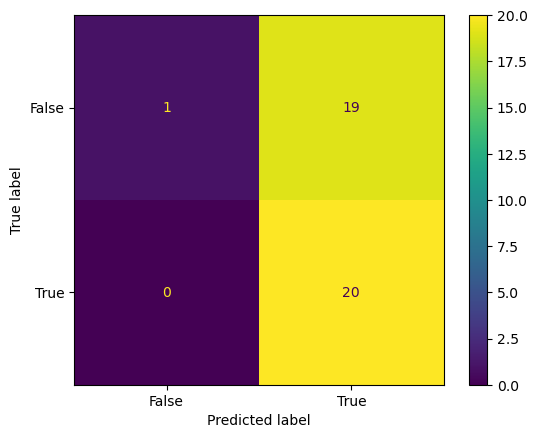

In [18]:
confusion_matrix(good_badDF)

In [19]:
add_values(dims,good_badDF,final)

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40


# happy---sad

In [20]:
contextHappySad="1. Her face lit up with a joyful smile.2. The sun was shining and birds were chirping, making her feel content.3. He felt a sense of elation when he accomplished his goal.4. The feeling of accomplishment brought her great happiness.5. She couldn't help but feel overjoyed about her upcoming vacation.6. Seeing her loved ones happy made her heart swell with joy.7. The laughter and chatter of friends made for a happy atmosphere.8. The delicious food and good company put him in a great mood.9. The satisfaction of completing a task brought a huge grin to her face.10. The cute puppy wagging its tail made her feel blissful.11. A warm hug from a loved one brought her immense happiness.12. The excitement of starting a new adventure made him feel giddy with joy.13. A successful day at work made her feel fulfilled and happy.14. The sound of children's laughter was music to her ears, making her happy.15. Dancing to her favorite song made her feel carefree and happy.16. The smell of fresh flowers put a smile on her face and made her happy.17. The warm sunshine and gentle breeze made for a perfect day, bringing joy.18. The feeling of love and acceptance from others made her feel happy and grateful.19. The delicious taste of her favorite dessert made her feel happy and content.20. Being surrounded by nature's beauty brought her peace and happiness.1. The old man sat alone in his dark and dingy apartment, reminiscing about the wife he lost many years ago.2. The abandoned puppy sat in the corner, trembling with fear and loneliness.3. The young girl stood at her mother's grave, tears streaming down her face.4. The soldier returned from war, only to find out that his wife had moved on and started a new life without him.5. The homeless man begged for money on the street corner, with no one to turn to for help.6. The abandoned child sat in the foster home, longing for a family to call his own.7. The cancer patient lay in the hospital bed, knowing that her time was running out.8. The elderly couple sat in the nursing home, their children too busy to visit them.9. The family mourned the loss of their beloved pet, who had been a loyal companion for many years.10. The victim of domestic abuse sat in silence, too afraid to speak out against her abuser.11. The young boy sat alone on the playground, watching the other children play and wishing he could join in.12. The immigrant family struggled to make ends meet in a new country, with no support from their loved ones back home.13. The student failed his exams, knowing that his dreams of a bright future had been shattered.14. The single mother worked two jobs, struggling to provide for her children and make ends meet.15. The elderly woman sat in her rocking chair, mourning the loss of her husband and the life they had shared together.16. The victim of a hit and run accident lay on the street, with no one stopping to help.17. The family of a missing person waited anxiously for news, not knowing if their loved one was alive or dead.18. The young girl was bullied at school, with no one to turn to for help or support.19. The victim of a natural disaster lost everything they owned, with no way to rebuild their life.20. The family of a terminally ill child struggled to come to terms with the fact that their chi"
train_sentences=preprocess_context(contextHappySad)
train_sentences

['[CLS]  Her face lit up with a joyful smile',
 '[CLS]  The sun was shining and birds were chirping, making her feel content',
 '[CLS]  He felt a sense of elation when he accomplished his goal',
 '[CLS]  The feeling of accomplishment brought her great happiness',
 "[CLS]  She couldn't help but feel overjoyed about her upcoming vacation",
 '[CLS]  Seeing her loved ones happy made her heart swell with joy',
 '[CLS]  The laughter and chatter of friends made for a happy atmosphere',
 '[CLS]  The delicious food and good company put him in a great mood',
 '[CLS]  The satisfaction of completing a task brought a huge grin to her face',
 '[CLS]  The cute puppy wagging its tail made her feel blissful',
 '[CLS]  A warm hug from a loved one brought her immense happiness',
 '[CLS]  The excitement of starting a new adventure made him feel giddy with joy',
 '[CLS]  A successful day at work made her feel fulfilled and happy',
 "[CLS]  The sound of children's laughter was music to her ears, making her 

In [21]:
dims=create_dimensions_list()


Enter word: happy
Antonym pair index 0
   Antonym pair Synset('happy.a.01')-----Synset('unhappy.a.01') 
        Definition Synset('happy.a.01') => enjoying or showing or marked by joy or pleasure 
        Definition Synset('unhappy.a.01') => experiencing or marked by or causing sadness or sorrow or discontent 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


In [22]:
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_hs=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_hs[sent]=float(list(res[2].values())[0])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  happy<------>unhappy
Definitions:  enjoying or showing or marked by joy or pleasure<------>experiencing or marked by or causing sadness or sorrow or discontent
Value: -0.88032216


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  happy<------>unhappy
Definitions:  enjoying or showing or marked by joy or pleasure<------>experiencing or marked by or causing sadness or sorrow or discontent
Value: -0.80662215


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  happy<------>unhappy
Definitions:  enjoying or showing or marked by joy or pleasure<------>experiencing or marked by or causing sadness or sorrow or discontent
Value: -0.6003408


Analyzing the word:  [CLS]
In the context of:  [CLS] A 

Top:  1
Dimension:  happy<------>unhappy
Definitions:  enjoying or showing or marked by joy or pleasure<------>experiencing or marked by or causing sadness or sorrow or discontent
Value:                      0.008125399


Analyzing the word:  [CLS]
In the context of:  [CLS] The online scammer stole thousands of dollars from unsuspecting victims.
Top:  1
Dimension:  happy<------>unhappy
Definitions:  enjoying or showing or marked by joy or pleasure<------>experiencing or marked by or causing sadness or sorrow or discontent
Value: -0.02802819


Analyzing the word:  [CLS]
In the context of:  [CLS] The pollution in the air caused respiratory problems for many people.
Top:  1
Dimension:  happy<------>unhappy
Definitions:  enjoying or showing or marked by joy or pleasure<------>experiencing or marked by or causing sadness or sorrow or discontent
Value:                      0.3108729


Analyzing the word:  [CLS]
In the context of:  [CLS] The earthquake caused widespread destruction and loss o

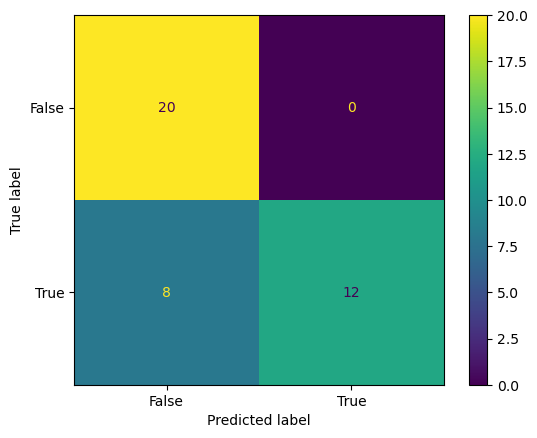

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40


In [23]:
HS_DF=create_df(results_hs)
confusion_matrix(HS_DF)
add_values(dims,HS_DF,final)

# hot-cold

In [25]:
dims=create_dimensions_list()


Enter word: hot
Antonym pair index 0
   Antonym pair Synset('hot.a.01')-----Synset('cold.a.01') 
        Definition Synset('hot.a.01') => used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning 
        Definition Synset('cold.a.01') => having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration 
 
 
 
Antonym pair index 1
   Antonym pair Synset('hot.a.03')-----Synset('cold.a.02') 
        Definition Synset('hot.a.03') => extended meanings; especially of psychological heat; marked by intensity or vehemence especially of passion or enthusiasm 
        Definition Synset('cold.a.02') => extended meanings; especially of psychological coldness; without human warmth or emotion 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning<------>having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration
Value: -0.65056944


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning<------>having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration
Value: -0.59094495


Analyzing the word:  [CLS]
In the context of

Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning<------>having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration
Value: -0.6691404


Analyzing the word:  [CLS]
In the context of:  [CLS] The smell coming from the garbage can was nauseating.
Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning<------>having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration
Value: -0.31153485


Analyzing the word:  [CLS]
In the context of:  [CLS] The food at the restaurant was undercooked and gave me food poisoning.
Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical

Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning<------>having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration
Value: -0.13114521


Analyzing the word:  [CLS]
In the context of:  [CLS] The discrimination against certain groups of people caused harm and inequality.
Top:  1
Dimension:  hot<------>cold
Definitions:  used of physical heat; having a high or higher than desirable temperature or giving off heat or feeling or causing a sensation of heat or burning<------>having a low or inadequate temperature or feeling a sensation of coldness or having been made cold by e.g. ice or refrigeration
Value: -0.09386413


Analyzing the word:  [CLS]
In the context of:  [CLS] The violence in the city led to a rise in crime and fear among residents.
Top:  1
Dimension:  hot<------>cold


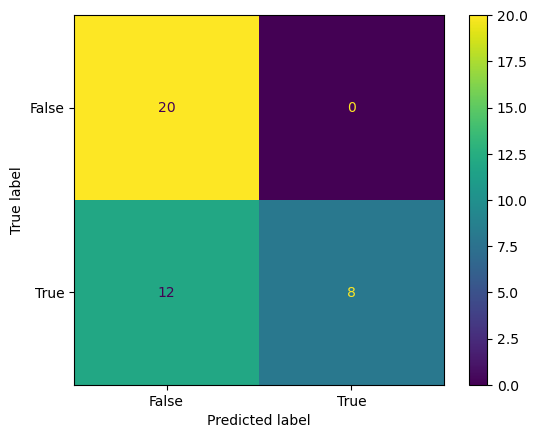

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40


In [26]:
contextHotCold="1. The sun was scorching and made me sweat profusely.2. The coffee was steaming and burned my tongue as I sipped it.3. The sand was blazing and made it uncomfortable to walk barefoot.4. The chili peppers had a fiery flavor that made my mouth tingle.5. The fireplace was roaring and gave off a comforting warmth.6. The curry had a spicy kick that made my nose run.7. The sauna was sweltering and made me feel like I was detoxing.8. The coffee mug was warm and comforting to hold in my hands.9. The firepit was blazing and provided a cozy gathering spot.10. The oven was sizzling and filled the kitchen with delicious aromas.11. The tea was piping hot and made me feel refreshed.12. The soup was simmering and filled the room with a savory scent.13. The steam rising from the pot was intense and made my skin feel dewy.14. The peppers in the stir fry had a zesty flavor that made my taste buds dance.15. The sauna was humid and made me feel like I was in a tropical jungle.16. The candles were flickering and gave off a warm and welcoming glow.17. The lava from the volcano was molten and destroyed everything in its path.18. The summer sun was scorching and made me seek shade.19. The spices in the dish were piquant and added a bold flavor to the meal.20. The oven mitts were warm and protected my hands from the heat of the oven.1. The icy wind cut through my jacket like a razor.2. The chilled water numbed my fingertips.3. The freezing air made my breath visible.4. The frosty ground crackled beneath my boots.5. The shivering trees stood motionless.6. The frigid temperature made my teeth chatter.7. The nippy breeze gave me goosebumps.8. The gelid air made my nose run.9. The chilly night sky was filled with twinkling stars.10. The wintry landscape was covered in a blanket of snow.11. The icy rain turned everything into a slippery mess.12. The snowflakes fell gently, creating a serene atmosphere.13. The frozen lake was a shimmering sheet of ice.14. The biting wind made me pull my coat tighter.15. The frost-covered leaves looked like delicate sculptures.16. The icy mist enveloped the mountains in an eerie haze.17. The icy river flowed silently through the valley.18. The frost on the windowpanes made intricate patterns.19. The chilly morning air made my eyes water.20. The frozen icicles hung from the roof like fragile crystals."
train_sentences=preprocess_context(contextHotCold)
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_hc=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_hc[sent]=float(list(res[2].values())[0])
    
HC_DF=create_df(results_hc)
confusion_matrix(HC_DF)
add_values(dims,HC_DF,final)

#  difficult --- easy 

In [28]:
dims=create_dimensions_list()

Enter word: difficult
Antonym pair index 0
   Antonym pair Synset('difficult.a.01')-----Synset('easy.a.01') 
        Definition Synset('difficult.a.01') => not easy; requiring great physical or mental effort to accomplish or comprehend or endure 
        Definition Synset('easy.a.01') => posing no difficulty; requiring little effort 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  difficult<------>easy
Definitions:  not easy; requiring great physical or mental effort to accomplish or comprehend or endure<------>posing no difficulty; requiring little effort
Value:                      0.96986324


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  difficult<------>easy
Definitions:  not easy; requiring great physical or mental effort to accomplish or comprehend or endure<------>posing no difficulty; requiring little effort
Value:                      0.689062


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  difficult<------>easy
Definitions:  not easy; requiring great physical or mental effort to accomplish or comprehend or endure<------>posing no difficulty; requ

Top:  1
Dimension:  difficult<------>easy
Definitions:  not easy; requiring great physical or mental effort to accomplish or comprehend or endure<------>posing no difficulty; requiring little effort
Value:                      0.19379304


Analyzing the word:  [CLS]
In the context of:  [CLS] The company laid off hundreds of employees without warning.
Top:  1
Dimension:  difficult<------>easy
Definitions:  not easy; requiring great physical or mental effort to accomplish or comprehend or endure<------>posing no difficulty; requiring little effort
Value:                      0.07316057


Analyzing the word:  [CLS]
In the context of:  [CLS] The news of a loved one's passing was heartbreaking.
Top:  1
Dimension:  difficult<------>easy
Definitions:  not easy; requiring great physical or mental effort to accomplish or comprehend or endure<------>posing no difficulty; requiring little effort
Value:                      0.4218713


Analyzing the word:  [CLS]
In the context of:  [CLS] The thief

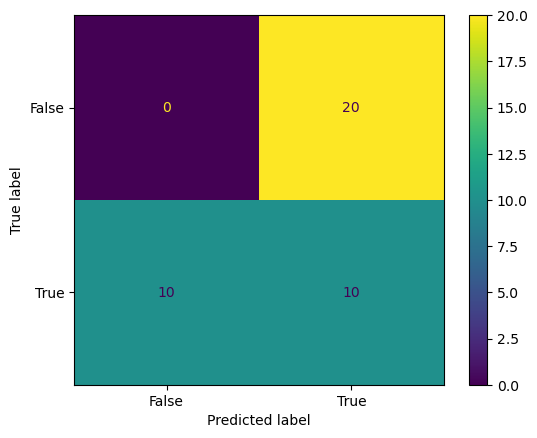

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40


In [29]:
context="1. The task at hand required immense effort and concentration. 2. It was no easy feat to accomplish what was being asked. 3. The challenge ahead was daunting and required a lot of perseverance. 4. The project was complex and required a great deal of problem-solving. 5. The situation demanded a significant amount of skill and attention. 6. The process was intricate and required careful attention to detail. 7. The task was arduous and required a lot of hard work. 8. It was a demanding task that required a lot of dedication. 9. The job was taxing and required a lot of energy. 10. The situation was delicate and required a lot of finesse. 11. The project was formidable and required a lot of courage. 12. The task was challenging and required a lot of creativity. 13. It was a strenuous task that required a lot of physical effort. 14. The job was intricate and required a lot of precision. 15. The situation was complex and required a lot of analysis.1. This math problem is very difficult to solve. 2. Climbing Mount Everest is a difficult task. 3. Learning a new language can be difficult, but it's worth it. 4. It is difficult to understand the complexities of the human brain. 5. Writing a novel is a difficult and time-consuming process.1. Learning a new language is not easy, but with practice, it can become easier. 2. It's easy to get lost in a new city, so it's important to have a map or GPS. 3. Cooking a gourmet meal may seem difficult, but with the right recipe, it can be easy. 4. It's easy to procrastinate, but it's important to stay focused on your goals. 5. Making a decision is never easy, especially when there are so many options.1. The task at hand requires little effort and can be accomplished quickly. 2. It's a breeze to complete the project with the right tools and resources. 3. The activity is so simple that even a child could do it. 4. The solution to the problem is straightforward and requires minimal thinking. 5. The process is uncomplicated and can be done in a few simple steps. 6. The task is so effortless that it can be done without breaking a sweat. 7. The task is not challenging and can be completed with minimal supervision. 8. The activity is so undemanding that it can be done while multitasking. 9. The solution is so obvious that it doesn't require much brainstorming. 10. The task is so straightforward that it can be done on autopilot. 11. The activity is so simple that it can be done without any specialized skills. 12. The task is so manageable that it can be completed in a short amount of time. 13. The solution is so clear that it can be implemented without any further discussion. 14. The activity is so effortless that it can be done while relaxing. 15. The task is so uncomplicated that it can be done without any prior training."
train_sentences=preprocess_context(context)
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_de=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_de[sent]=float(list(res[2].values())[0])
    
DE_DF=create_df(results_de)
confusion_matrix(DE_DF)
add_values(dims,DE_DF,final)

# big-small

In [30]:
dims=create_dimensions_list()

Enter word: BIG
Antonym pair index 0
   Antonym pair Synset('large.a.01')-----Synset('small.a.01') 
        Definition Synset('large.a.01') => above average in size or number or quantity or magnitude or extent 
        Definition Synset('small.a.01') => limited or below average in number or quantity or magnitude or extent 
 
 
 
Antonym pair index 1
   Antonym pair Synset('big.r.03')-----Synset('small.r.01') 
        Definition Synset('big.r.03') => on a grand scale 
        Definition Synset('small.r.01') => on a small scale 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  large<------>small
Definitions:  above average in size or number or quantity or magnitude or extent<------>limited or below average in number or quantity or magnitude or extent
Value:                      0.32797515


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  large<------>small
Definitions:  above average in size or number or quantity or magnitude or extent<------>limited or below average in number or quantity or magnitude or extent
Value:                      0.028197385


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  large<------>small
Definitions:  above average in size or number or quantity or magnitude or extent<------>limited or below average in number or quantity or mag

Top:  1
Dimension:  large<------>small
Definitions:  above average in size or number or quantity or magnitude or extent<------>limited or below average in number or quantity or magnitude or extent
Value: -0.25990772


Analyzing the word:  [CLS]
In the context of:  [CLS] The news of a loved one's passing was heartbreaking.
Top:  1
Dimension:  large<------>small
Definitions:  above average in size or number or quantity or magnitude or extent<------>limited or below average in number or quantity or magnitude or extent
Value:                      0.07484619


Analyzing the word:  [CLS]
In the context of:  [CLS] The thief stole all of the valuables from the house.
Top:  1
Dimension:  large<------>small
Definitions:  above average in size or number or quantity or magnitude or extent<------>limited or below average in number or quantity or magnitude or extent
Value:                      0.031335287


Analyzing the word:  [CLS]
In the context of:  [CLS] The online scammer stole thousands of do

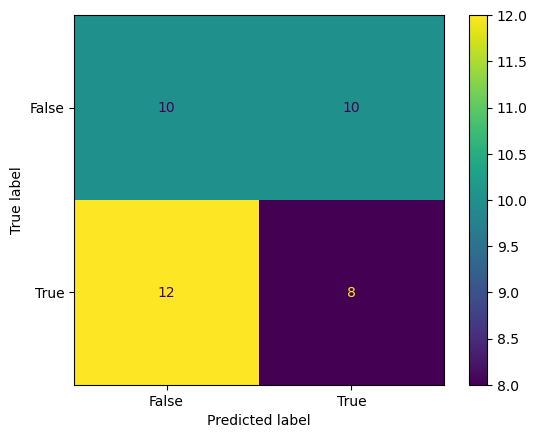

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40
4,"[[large.a.01, small.a.01]]",0.421053,0.4,0.444444,0.450,40


In [31]:
context="1. The towering skyscraper stretched towards the sky. 2. The massive elephant trampled through the jungle. 3. The expansive ocean seemed to have no end in sight. 4. The colossal mountain range loomed in the distance. 5. The grandiose cathedral was a sight to behold. 6. The prodigious ship sailed across the vast sea. 7. The monumental statue stood proudly in the city center. 8. The immense forest was a maze of towering trees. 9. The substantial whale breached the surface of the water. 10. The extensive desert was a sea of sand as far as the eye could see. 11. The impressive glacier stretched for miles. 12. The gigantic boulder blocked the path completely. 13. The towering bridge spanned across the wide river. 14. The massive meteorite left a crater miles wide. 15. The grand palace was fit for a king and his court.1. The big elephant trumpeted loudly as it walked through the savannah. 2. The big, fluffy dog wagged its tail excitedly when its owner arrived home. 3. The big, ominous storm cloud loomed over the horizon, threatening to unleash its fury. 4. The big, luxurious yacht sailed gracefully through the open sea. 5. The big, sprawling city was a maze of skyscrapers and bustling streets.1. The small kitten curled up in the warm sunbeam. 2. A small bird chirped from the tree branch above. 3. The small town was nestled in the rolling hills. 4. She wore a small pendant around her neck. 5. The small flower bloomed brightly in the garden.1. The tiny teacup fit perfectly in her hand. 2. The little seedling emerged from the soil. 3. The miniature figurine was intricately detailed. 4. The petite ring sparkled on her finger. 5. The baby bird was barely visible in the nest. 6. The dainty butterfly landed on the flower petal. 7. The compact camera captured stunning photos. 8. The wee mouse scurried across the floor. 9. The delicate snowflake melted on her fingertip. 10. The slim pencil wrote in fine lines. 11. The fine thread was barely visible to the eye. 12. The minute bug crawled along the leaf. 13. The slender blade sliced through the bread. 14. The diminutive toy car zoomed across the floor. 15. The tiny book fit in the palm of her hand."
train_sentences=preprocess_context(context)

out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_bs=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_bs[sent]=float(list(res[2].values())[0])
    
BS_DF=create_df(results_bs)
confusion_matrix(BS_DF)
add_values(dims,BS_DF,final)

# Fast - Slow 

In [32]:
dims=create_dimensions_list()
context="1. The cheetah raced across the savannah in a blur. 2. The race car zoomed past the finish line in a flash. 3. The hare sprinted ahead of the tortoise with ease. 4. The roller coaster hurtled down the track at breakneck speed. 5. The windsurfing board skimmed over the waves effortlessly. 6. The rocket shot into space with incredible velocity. 7. The motorcycle roared down the highway leaving dust in its wake. 8. The speedboat sliced through the water like a knife.10. The bullet train streaked through the countryside in a blur. 11. The fighter jet soared through the sky at supersonic speed. 12. The downhill skier hurtled down the slope with incredible momentum. 13. The greyhound raced around the track with lightning agility. 14. The bobsled hurtled down the icy track at dizzying speed. 15. The Formula One car flew around the racetrack with remarkable swiftness.30. The fast-approaching exam had the students studying feverishly, hoping to do well. 31. The fast-moving stock market was a source of excitement and anxiety for investors. 32. The fast-drying paint allowed the decorator to finish the job quickly and efficiently. 33. The fast-moving conveyor belt at the airport moved the luggage from one place to another in a matter of seconds. 34. The fast-revolving merry-go-round made the children giggle with delight as they rode on it. 35. The fast-approaching finish line spurred the marathon runner on, giving him the energy to complete the race.1. The snail made its way across the garden at a leisurely pace. 2. The elderly woman walked with a deliberate gait, taking her time. 3. The tortoise moved steadily along the path, never in a hurry. 4. The traffic in the city centre crawled along at a snail's pace. 5. The sloth hung from the tree branch, barely moving at all. 6. The river flowed languidly through the valley, taking its time. 7. The seedling grew slowly, inching its way towards the sunlight. 8. The caterpillar inched along the twig, taking its sweet time. 9. The turtle swam gracefully through the water, never in a rush. 10. The glacier moved imperceptibly, inching forward over time. 11. The old grandfather clock ticked away slowly, marking the hours. 12. The computer took ages to load, frustrating the user. 13. The slothful student took his time to complete the assignment. 14. The snail-like service at the restaurant tested the patience of the customers. 15. The sleepy cat stretched lazily, taking its time to wake up.1. The turtle moves slowly across the road. 2. The snail crawls at a slow pace. 3. The traffic is moving slow today. 4. The computer is running slow. 5. The old man walks with a slow gait."
train_sentences=preprocess_context(context)

Enter word: fast
Antonym pair index 0
   Antonym pair Synset('fast.a.01')-----Synset('slow.a.01') 
        Definition Synset('fast.a.01') => acting or moving or capable of acting or moving quickly 
        Definition Synset('slow.a.01') => not moving quickly; taking a comparatively long time 
 
 
 
Antonym pair index 1
   Antonym pair Synset('fast.a.02')-----Synset('slow.a.04') 
        Definition Synset('fast.a.02') => (used of timepieces) indicating a time ahead of or later than the correct time 
        Definition Synset('slow.a.04') => (used of timepieces) indicating a time earlier than the correct time 
 
 
 
Antonym pair index 2
   Antonym pair Synset('fast.a.03')-----Synset('slow.a.02') 
        Definition Synset('fast.a.03') => at a rapid tempo 
        Definition Synset('slow.a.02') => at a slow tempo 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  fast<------>slow
Definitions:  acting or moving or capable of acting or moving quickly<------>not moving quickly; taking a comparatively long time
Value:                      0.20791171


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  fast<------>slow
Definitions:  acting or moving or capable of acting or moving quickly<------>not moving quickly; taking a comparatively long time
Value:                      1.3053831


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  fast<------>slow
Definitions:  acting or moving or capable of acting or moving quickly<------>not moving quickly; taking a comparatively long time
Value:                      0.4078604


Analyzing the word:  [CLS]
In the c

Top:  1
Dimension:  fast<------>slow
Definitions:  acting or moving or capable of acting or moving quickly<------>not moving quickly; taking a comparatively long time
Value:                      0.6013359


Analyzing the word:  [CLS]
In the context of:  [CLS] The online scammer stole thousands of dollars from unsuspecting victims.
Top:  1
Dimension:  fast<------>slow
Definitions:  acting or moving or capable of acting or moving quickly<------>not moving quickly; taking a comparatively long time
Value:                      0.77215856


Analyzing the word:  [CLS]
In the context of:  [CLS] The pollution in the air caused respiratory problems for many people.
Top:  1
Dimension:  fast<------>slow
Definitions:  acting or moving or capable of acting or moving quickly<------>not moving quickly; taking a comparatively long time
Value:                      0.711938


Analyzing the word:  [CLS]
In the context of:  [CLS] The earthquake caused widespread destruction and loss of life.
Top:  1
Dimens

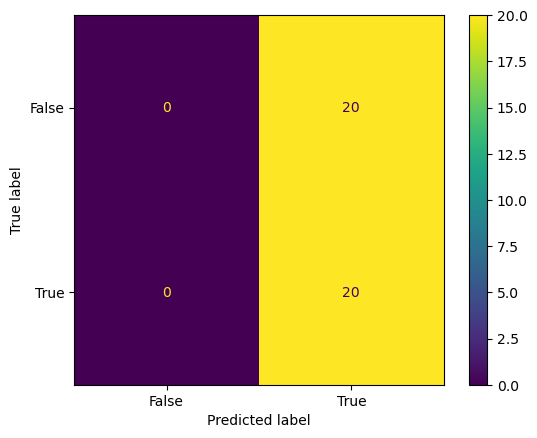

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40
4,"[[large.a.01, small.a.01]]",0.421053,0.4,0.444444,0.450,40
5,"[[fast.a.01, slow.a.01]]",0.666667,1.0,0.500000,0.500,40


In [34]:
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_FS=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_FS[sent]=float(list(res[2].values())[0])
    
FS_DF=create_df(results_FS)
confusion_matrix(FS_DF)
add_values(dims,FS_DF,final)

#  Rich - Poor 

In [35]:
dims=create_dimensions_list()

Enter word: RICH
Antonym pair index 0
   Antonym pair Synset('rich_people.n.01')-----Synset('poor_people.n.01') 
        Definition Synset('rich_people.n.01') => people who have possessions and wealth (considered as a group) 
        Definition Synset('poor_people.n.01') => people without possessions or wealth (considered as a group) 
 
 
 
Antonym pair index 1
   Antonym pair Synset('rich.a.01')-----Synset('poor.a.02') 
        Definition Synset('rich.a.01') => possessing material wealth 
        Definition Synset('poor.a.02') => having little money or few possessions 
 
 
 
Antonym pair index 2
   Antonym pair Synset('rich.a.02')-----Synset('poor.a.04') 
        Definition Synset('rich.a.02') => having an abundant supply of desirable qualities or substances (especially natural resources) 
        Definition Synset('poor.a.04') => lacking in specific resources, qualities or substances 
 
 
 
Antonym pair index 3
   Antonym pair Synset('rich.a.07')-----Synset('lean.a.02') 
        Defi

In [36]:
context="1. The billionaire was incredibly rich, with more money than he could ever spend. 2. She felt blessed to have a rich family who could support her dreams. 3. The soil in that area is incredibly rich, making it perfect for agriculture. 4. The painting was incredibly detailed and rich in color. 5. The chocolate cake was rich and decadent, perfect for a special occasion.1. He lived a life of luxury, surrounded by opulence and extravagance. 2. Her bank account was always overflowing with an abundance of funds. 3. The mansion was adorned with expensive artwork and furnishings, indicating wealth beyond measure. 4. His wardrobe consisted of designer labels and custom-made suits, displaying his affluence. 5. The private jet waiting on the runway was a clear indication of their prosperity. 6. Their vacation home was situated in an exclusive enclave reserved for the elite. 7. The lavish party was filled with celebrities and high society, showcasing their financial status. 8. The car parked outside was a high-end model known for its luxury and performance. 9. The yacht they sailed on was a behemoth of the sea, a symbol of their immense wealth. 10. The villa they rented for the summer was fit for royalty, complete with a private pool and butler service. 11. The jewelry she wore was adorned with precious gems and metals, indicating her high net worth. 12. The charity event was attended by philanthropists and donors, highlighting their generosity and wealth. 13. The investment portfolio they managed was diverse and profitable, generating significant returns. 14. The watch on his wrist was a limited edition timepiece coveted by collectors, revealing his financial success. 15. The real estate empire they built spanned across multiple countries, a testament to their wealth and power.1. He lived in a run-down apartment with peeling wallpaper and stained carpets. 2. Her clothes were old and tattered, with holes in the sleeves and frayed hems. 3. The family's meals consisted of canned goods and cheap, processed foods. 4. His shoes were worn out and had holes in the soles. 5. Their only mode of transportation was an old, rusty bicycle. 6. The house was small and cramped, with only one bedroom for the whole family. 7. The children didn't have any toys or games to play with, only a few broken items. 8. Their furniture was mismatched and cobbled together from thrift stores and hand-me-downs. 9. The heating didn't work properly, leaving the family cold and shivering in the winter. 10. They had to rely on public transportation to get anywhere, which was often unreliable and slow. 11. The electricity was often shut off due to unpaid bills, leaving them in the dark. 12. They couldn't afford medical care, so they often had to suffer through illnesses without treatment. 13. The neighborhood was rough and dangerous, with high crime rates and dilapidated buildings. 14. They had to wash their clothes by hand because they couldn't afford a washing machine. 15. The school they attended was underfunded and overcrowded, with outdated textbooks and limited resources.1. The poor children were begging for food on the streets. 2. The poor man lived in a shabby hut. 3. The poor have limited access to education. 4. The poor struggle to meet their basic needs. 5. The poor are often marginalized in society."
train_sentences=preprocess_context(context)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Please enter at least one example sentence for the word: rich_people
Unable to create POLAR dimensions.
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  rich_people<------>poor_people
Definitions:  people who have possessions and wealth (considered as a group)<------>people without possessions or wealth (considered as a group)
Value:                      0.20791171


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  rich_people<------>poor_people
Definitions:  people who have possessions and wealth (considered as a group)<------>people without possessions or wealth (considered as a group)
Value:                      1.3053831


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  rich_people<------>poor_people
Definitions:  people who have

Top:  1
Dimension:  rich_people<------>poor_people
Definitions:  people who have possessions and wealth (considered as a group)<------>people without possessions or wealth (considered as a group)
Value:                      0.6481733


Analyzing the word:  [CLS]
In the context of:  [CLS] The company laid off hundreds of employees without warning.
Top:  1
Dimension:  rich_people<------>poor_people
Definitions:  people who have possessions and wealth (considered as a group)<------>people without possessions or wealth (considered as a group)
Value:                      0.15766329


Analyzing the word:  [CLS]
In the context of:  [CLS] The news of a loved one's passing was heartbreaking.
Top:  1
Dimension:  rich_people<------>poor_people
Definitions:  people who have possessions and wealth (considered as a group)<------>people without possessions or wealth (considered as a group)
Value:                      0.7681058


Analyzing the word:  [CLS]
In the context of:  [CLS] The thief stole all

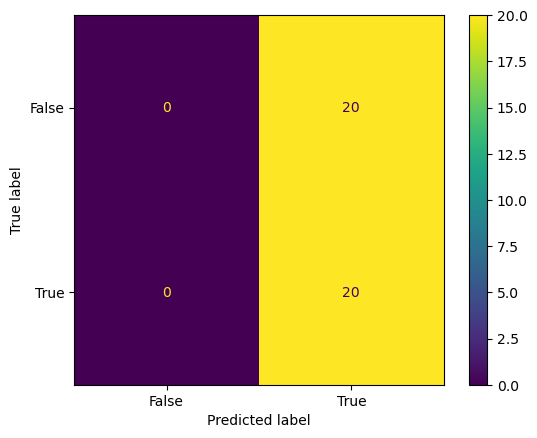

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40
4,"[[large.a.01, small.a.01]]",0.421053,0.4,0.444444,0.450,40
5,"[[fast.a.01, slow.a.01]]",0.666667,1.0,0.500000,0.500,40
6,"[[rich_people.n.01, poor_people.n.01]]",0.666667,1.0,0.500000,0.500,40


In [37]:
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_RP=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_RP[sent]=float(list(res[2].values())[0])
    
RP_DF=create_df(results_RP)
confusion_matrix(RP_DF)
add_values(dims,RP_DF,final)

#  Love - Hate

In [38]:
dims=create_dimensions_list()

Enter word: LOVE
Antonym pair index 0
   Antonym pair Synset('love.v.01')-----Synset('hate.v.01') 
        Definition Synset('love.v.01') => have a great affection or liking for 
        Definition Synset('hate.v.01') => dislike intensely; feel antipathy or aversion towards 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection or liking for<------>dislike intensely; feel antipathy or aversion towards
Value:                      0.18849634


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection or liking for<------>dislike intensely; feel antipathy or aversion towards
Value: -0.32315928


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection or liking for<------>dislike intensely; feel antipathy or aversion towards
Value:                      0.22041917


Analyzing the word:  [CLS]
In the context of:  [CLS] A cozy blanket on a chilly day.
Top:  1
Dimension:  lo

Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection or liking for<------>dislike intensely; feel antipathy or aversion towards
Value:                      0.6594748


Analyzing the word:  [CLS]
In the context of:  [CLS] The earthquake caused widespread destruction and loss of life.
Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection or liking for<------>dislike intensely; feel antipathy or aversion towards
Value:                      0.6760666


Analyzing the word:  [CLS]
In the context of:  [CLS] The computer virus wiped out all of the important files on the computer.
Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection or liking for<------>dislike intensely; feel antipathy or aversion towards
Value:                      1.277633


Analyzing the word:  [CLS]
In the context of:  [CLS] The political scandal caused a loss of trust in the government.
Top:  1
Dimension:  love<------>hate
Definitions:  have a great affection o

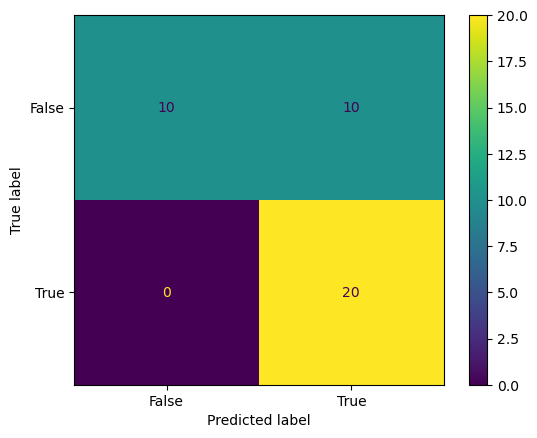

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40
4,"[[large.a.01, small.a.01]]",0.421053,0.4,0.444444,0.450,40
5,"[[fast.a.01, slow.a.01]]",0.666667,1.0,0.500000,0.500,40
6,"[[rich_people.n.01, poor_people.n.01]]",0.666667,1.0,0.500000,0.500,40
7,"[[love.v.01, hate.v.01]]",0.800000,1.0,0.666667,0.750,40


In [39]:
context="1. She felt a deep love for her children. 2. Their love for each other was evident in the way they looked at each other. 3. He was consumed by his love for her. 4. Love is the most powerful force in the universe. 5. They fell in love at first sight. 1. The couple shared a deep and unbreakable bond. 2. Their connection was stronger than anything they had ever known. 3. They were two halves of a whole, perfectly matched in every way. 4. Their affection for each other was evident in every gesture and glance. 5. They were inseparable, always by each other's side. 6. Their relationship was built on trust, respect, and understanding. 7. They complemented each other perfectly, like two pieces of a puzzle. 8. The way they looked at each other said more than words ever could. 9. They were each other's rock, always there to support and comfort one another. 10. Their love was a flame that burned bright, never dimming or fading. 11. They shared a connection that transcended time and distance. 12. Their union was a beautiful and sacred thing, to be cherished and nurtured. 13. They were partners in every sense of the word, sharing their joys and sorrows. 14. They had a chemistry that was undeniable, a natural attraction that drew them together. 15. They were a team, working together to overcome any obstacle that came their way.1. She felt a deep and intense anger towards him. 2. Their relationship was marred by a growing sense of resentment. 3. He harbored a strong dislike for his neighbor. 4. She couldn't stand to be in the same room as him. 5. They had a bitter and acrimonious relationship. 6. He held a grudge against her that never seemed to fade. 7. She felt a burning anger that consumed her whenever she thought of him. 8. They had an animosity towards each other that was palpable. 9. He had a deep-seated aversion to anything that reminded him of his past. 10. She felt a loathing for him that she could not explain. 11. They had a mutual antipathy that had been simmering for years. 12. He felt a contempt for his boss that he struggled to hide. 13. She had a disdain for anyone who didn't share her beliefs. 14. They had a seething resentment towards each other that never seemed to dissipate. 15. He felt a repugnance towards his former friend that he couldn't shake.1. He felt a burning hate towards his ex-wife. 2. Hatred is a destructive emotion that can consume a person. 3. They had a mutual hate for each other that was palpable. 4. She couldn't hide her hate for her boss. 5. Hatred is often a result of deep-seated resentment."
train_sentences=preprocess_context(context)



out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_lh=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_lh[sent]=float(list(res[2].values())[0])
    
LH_DF=create_df(results_lh)
confusion_matrix(LH_DF)
add_values(dims,LH_DF,final)

# strong - weak

In [40]:
dims=create_dimensions_list()

Enter word: STRONG
Antonym pair index 0
   Antonym pair Synset('strong.a.01')-----Synset('weak.a.01') 
        Definition Synset('strong.a.01') => having strength or power greater than average or expected 
        Definition Synset('weak.a.01') => wanting in physical strength 
 
 
 
Antonym pair index 1
   Antonym pair Synset('potent.a.03')-----Synset('impotent.a.01') 
        Definition Synset('potent.a.03') => having a strong physiological or chemical effect; ; ; , 
        Definition Synset('impotent.a.01') => lacking power or ability; - Freeman J.Dyson 
 
 
 
Enter the index of desired antonym pair: 0
 
 
 
Enter word: 


In [41]:
context="1. He possessed an unwavering determination that propelled him forward. 2. Her willpower was unrelenting, even in the face of adversity. 3. He had a fierce resolve that never faltered. 4. Her fortitude allowed her to overcome any obstacle. 5. He was steadfast in his beliefs, never swayed by outside influences. 6. She had an indomitable spirit that refused to be broken. 7. He displayed a powerful conviction that inspired others to follow. 8. Her perseverance was unmatched, always pushing herself to the limit. 9. He had an ironclad discipline that kept him focused on his goals. 10. She possessed an inner strength that radiated from within. 11. He was unyielding in his pursuit of excellence. 12. Her tenacity was awe-inspiring, never giving up despite setbacks. 13. He had an unshakeable confidence that propelled him to success. 14. She displayed a resolute determination that was unmatched. 15. His unwavering courage in the face of danger was truly remarkable.1. She has a strong determination to succeed. 2. He lifted the heavy weight with his strong arms. 3. The athlete has a strong chance of winning the race. 4. The foundation of the building must be strong to withstand earthquakes. 5. She has a strong personality and is not easily swayed. 1. The bridge was weak and collapsed under the weight of the truck. 2. His immune system was weak and he fell sick often. 3. The team's defense was weak and they lost the game. 4. She has a weak voice and is often not heard in meetings. 5. The battery was weak and needed to be replaced.1. The fabric was fragile and easily tore. 2. The plant was delicate and required constant care. 3. The threadbare sweater was in danger of falling apart. 4. The rickety chair wobbled and creaked under his weight. 5. The tiny bird's wings were frail and delicate. 6. The old man's grip was feeble and weak. 7. The thin ice cracked under the weight of the skater. 8. The rusted chain was brittle and easily snapped. 9. The sickly baby was frail and weak. 10. The shallow stream was easily crossed. 11. The dim light was faint and barely visible. 12. The dying flower was wilting and drooping. 13. The cracked glass was fragile and easily shattered. 14. The thin paper tore easily in his hands. 15. The faded photograph was dull and lacked vibrancy."
train_sentences=preprocess_context(context)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------>wanting in physical strength
Value: -0.19039007


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------>wanting in physical strength
Value:                      0.14162688


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------>wanting in physical strength
Value: -0.10017876


Analyzing the word:  [CLS]
In the context of:  [CLS] A cozy blanket on a chilly day.
Top:  1
Dimension:  strong<------>weak
Definitio

Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------>wanting in physical strength
Value: -0.48109394


Analyzing the word:  [CLS]
In the context of:  [CLS] The earthquake caused widespread destruction and loss of life.
Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------>wanting in physical strength
Value: -0.28789335


Analyzing the word:  [CLS]
In the context of:  [CLS] The computer virus wiped out all of the important files on the computer.
Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------>wanting in physical strength
Value:                      0.10937077


Analyzing the word:  [CLS]
In the context of:  [CLS] The political scandal caused a loss of trust in the government.
Top:  1
Dimension:  strong<------>weak
Definitions:  having strength or power greater than average or expected<------

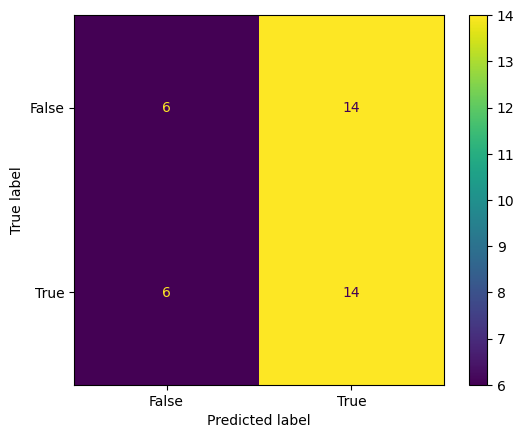

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40
4,"[[large.a.01, small.a.01]]",0.421053,0.4,0.444444,0.450,40
5,"[[fast.a.01, slow.a.01]]",0.666667,1.0,0.500000,0.500,40
6,"[[rich_people.n.01, poor_people.n.01]]",0.666667,1.0,0.500000,0.500,40
7,"[[love.v.01, hate.v.01]]",0.800000,1.0,0.666667,0.750,40
8,"[[strong.a.01, weak.a.01]]",0.583333,0.7,0.500000,0.500,40


In [42]:


out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_SW=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_SW[sent]=float(list(res[2].values())[0])
    
SW_DF=create_df(results_SW)
confusion_matrix(SW_DF)
add_values(dims,SW_DF,final)

# old - new

In [43]:
dims=create_dimensions_list()

Enter word: OLD
Antonym pair index 0
   Antonym pair Synset('old.a.01')-----Synset('young.a.01') 
        Definition Synset('old.a.01') => (used especially of persons) having lived for a relatively long time or attained a specific age 
        Definition Synset('young.a.01') => (used of living things especially persons) in an early period of life or development or growth 
 
 
 
Antonym pair index 1
   Antonym pair Synset('old.a.02')-----Synset('new.a.01') 
        Definition Synset('old.a.02') => of long duration; not new 
        Definition Synset('new.a.01') => not of long duration; having just (or relatively recently) come into being or been made or acquired or discovered 
 
 
 
Enter the index of desired antonym pair: 1
 
 
 
Enter word: 


In [44]:
context="1. The antique car was a relic from a bygone era. 2. The historic building had stood for centuries. 3. The classic novel was a timeless masterpiece. 4. The vintage record player was a treasure from the past. 5. The ancient artifact was a fascinating piece of history. 6. The traditional recipe had been passed down for generations. 7. The weathered barn had weathered many storms. 8. The traditional dance had been performed for hundreds of years. 9. The nostalgic photograph captured a moment in time. 10. The timeless painting was a work of art. 11. The traditional clothing was a symbol of cultural heritage. 12. The rustic cabin had a cozy, old-world charm. 13. The historic document had been preserved for centuries. 14. The classic film was a beloved masterpiece of cinema. 15. The vintage typewriter was a reminder of a simpler time.1. The old man sat on the bench, feeding the pigeons. 2. The old book had yellowed pages and a musty smell. 3. The old car had a classic design and was highly sought after. 4. The old house had a charm that modern houses lacked. 5. The old bridge was in need of repair. 1. The latest smartphone had state-of-the-art features. 2. The innovative technology was cutting-edge and advanced. 3. The freshly-painted walls gave the room a modern look. 4. The recently-launched brand had a distinct identity and style. 5. The current fashion trends were fresh and exciting. 6. The latest model of the car had sleek lines and a modern design. 7. The contemporary art exhibit showcased new artists and styles. 8. The newly-constructed building had modern architecture and amenities. 9. The current music scene was vibrant and experimental. 10. The modern kitchen appliances had advanced features and functions. 11. The updated software had improved performance and security. 12. The current political climate was marked by new ideas and policies. 13. The young company had a fresh perspective and innovative ideas. 14. The recently-released movie had groundbreaking special effects. 15. The innovative gadget had futuristic features and functions.1. I'm excited to try out my new recipe tonight. 2. The new student just arrived in class. 3. The bookstore just got in some new novels. 4. I need to buy a new pair of shoes. 5. The city is planning to build a new park. "
train_sentences=preprocess_context(context)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start forwarding the Polar opposites ...
This word is missing in a corresponding example sentence: new
Unable to create POLAR dimensions.
Analyzing the word:  [CLS]
In the context of:  [CLS] A kind gesture from a stranger. A good book that captures your imagination.
Top:  1
Dimension:  old<------>new
Definitions:  of long duration; not new<------>not of long duration; having just (or relatively recently) come into being or been made or acquired or discovered
Value: -0.19039007


Analyzing the word:  [CLS]
In the context of:  [CLS] A peaceful moment in nature.
Top:  1
Dimension:  old<------>new
Definitions:  of long duration; not new<------>not of long duration; having just (or relatively recently) come into being or been made or acquired or discovered
Value:                      0.14162688


Analyzing the word:  [CLS]
In the context of:  [CLS] A favorite song that makes you happy.
Top:  1
Dimension:  old<------>new
Definitions:  of long duration; not new<------>not of long duration; ha

Top:  1
Dimension:  old<------>new
Definitions:  of long duration; not new<------>not of long duration; having just (or relatively recently) come into being or been made or acquired or discovered
Value:                      0.12986507


Analyzing the word:  [CLS]
In the context of:  [CLS] The news of a loved one's passing was heartbreaking.
Top:  1
Dimension:  old<------>new
Definitions:  of long duration; not new<------>not of long duration; having just (or relatively recently) come into being or been made or acquired or discovered
Value:                      0.24618298


Analyzing the word:  [CLS]
In the context of:  [CLS] The thief stole all of the valuables from the house.
Top:  1
Dimension:  old<------>new
Definitions:  of long duration; not new<------>not of long duration; having just (or relatively recently) come into being or been made or acquired or discovered
Value:                      0.25870353


Analyzing the word:  [CLS]
In the context of:  [CLS] The online scammer stole

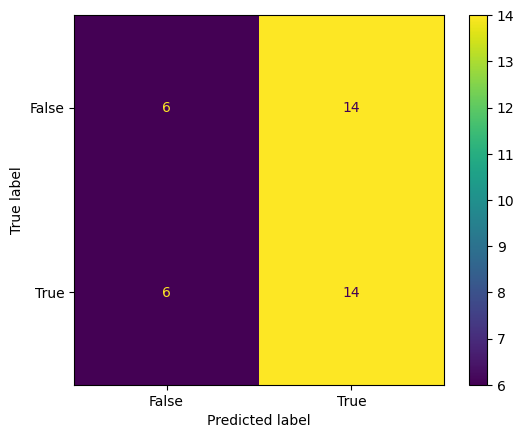

,Antonym_pair,F1,RECALL,PRESICION,ACCURACY,Number_of_predictions
0,"[[good.n.03, bad.n.01]]",0.677966,1.0,0.512821,0.525,40
1,"[[happy.a.01, unhappy.a.01]]",0.750000,0.6,1.000000,0.800,40
2,"[[hot.a.01, cold.a.01]]",0.571429,0.4,1.000000,0.700,40
3,"[[difficult.a.01, easy.a.01]]",0.400000,0.5,0.333333,0.250,40
4,"[[large.a.01, small.a.01]]",0.421053,0.4,0.444444,0.450,40
5,"[[fast.a.01, slow.a.01]]",0.666667,1.0,0.500000,0.500,40
6,"[[rich_people.n.01, poor_people.n.01]]",0.666667,1.0,0.500000,0.500,40
7,"[[love.v.01, hate.v.01]]",0.800000,1.0,0.666667,0.750,40
8,"[[strong.a.01, weak.a.01]]",0.583333,0.7,0.500000,0.500,40
9,"[[old.a.02, new.a.01]]",0.583333,0.7,0.500000,0.500,40


In [45]:
out_path = 'antonyms/example/'

create_lookup_files(dims, out_path)
tokenizer, model = getBert()
# create the base change matrix (this might take some time)
createPolarDimension(model, tokenizer, out_path=out_path, antonym_path=out_path + "antonym_wordnet_example_sentences_readable_extended.txt")
antonym_path = out_path + "polar_dimensions.pkl"
word = '[CLS]'
results_ON=defaultdict()
for sent in train_tokens:

    res=analyzeWord(word, sent, model=model,tokenizer=tokenizer, antonym_path=antonym_path, lookup_path=out_path, numberPolar=1,method="projection")
    results_ON[sent]=float(list(res[2].values())[0])
    
ON_DF=create_df(results_ON)
confusion_matrix(ON_DF)
add_values(dims,ON_DF,final)